In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

In [ ]:
zippath='/content/drive/MyDrive/MURA.zip'
unzip='/content/MURA'


In [ ]:
with zipfile.ZipFile(zippath,'r') as zip_ref:
  zip_ref.extractall(unzip)

print('files extracted successfully')

files extracted successfully


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device',device)

using device cuda


In [ ]:
train=pd.read_csv('/content/MURA/MURA-v1.1/train_image_paths.csv',header=None)
valid=pd.read_csv('/content/MURA/MURA-v1.1/valid_image_paths.csv',header=None)
train_labels=pd.read_csv('/content/MURA/MURA-v1.1/train_labeled_studies.csv',header=None)
valid_labels=pd.read_csv('/content/MURA/MURA-v1.1/valid_labeled_studies.csv',header=None)


In [ ]:
train[0]

,0
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [ ]:
def get_label(p):
  return 1 if 'positive' in p else 0

In [ ]:
train['label']=train[0].apply(get_label)
valid['label']=valid[0].apply(get_label)

In [ ]:
train.head()

,0,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1


In [ ]:
valid.head()

,0,label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1


In [ ]:
train[0]

,0
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [ ]:
train[0]=train[0].apply(lambda x: os.path.join('/content/MURA',x))
valid[0]=valid[0].apply(lambda x: os.path.join('/content/MURA',x))

In [ ]:
train[0]

,0
0,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...
1,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...
2,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...
3,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...
4,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...
...,...
36803,/content/MURA/MURA-v1.1/train/XR_HAND/patient1...
36804,/content/MURA/MURA-v1.1/train/XR_HAND/patient1...
36805,/content/MURA/MURA-v1.1/train/XR_HAND/patient1...
36806,/content/MURA/MURA-v1.1/train/XR_HAND/patient1...


In [ ]:
class muradataset(Dataset):
  def __init__(self,df,transform=None):
    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path=self.df.iloc[index,0]
    label=self.df.iloc[index,1]

    image=Image.open(image_path).convert('RGB')

    if self.transform:
      image=self.transform(image)

    return image,torch.tensor(label,dtype=torch.float32)



In [ ]:
img_size=224
train_transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

valid_transform=transforms.Compose([transforms.Resize((img_size,img_size)),transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])



In [ ]:
training_dataset=muradataset(train,transform=train_transform)
validation_dataset=muradataset(valid,transform=valid_transform)

In [ ]:
batch_size=32
train_loader=DataLoader(training_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(validation_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
CHECKPOINT_PATH=os.path.join(HOME,'weights','sam_vit_h_4b8939.pth')
print(CHECKPOINT_PATH,"exist :", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth exist : True


In [ ]:
MODEL_TYPE='vit_h'

In [ ]:
from segment_anything import sam_model_registry,SamAutomaticMaskGenerator,SamPredictor
sam=sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=device)

In [ ]:
import supervision as sv


In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
bounding_box=pd.read_csv('/content/drive/MyDrive/train_bbox.csv')

In [ ]:
bounding_box['path'] = bounding_box['path'].apply(lambda x: os.path.join('/content/MURA', x))

In [ ]:
bounding_box['path']=bounding_box['path'].str.replace('\\','/',regex=False)

In [ ]:
bounding_box.head()

,path,x1,y1,x2,y2
0,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...,86,86,136,136
1,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...,119,55,169,105
2,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...,87,54,137,104
3,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...,86,87,136,137
4,/content/MURA/MURA-v1.1/train/XR_SHOULDER/pati...,119,118,169,168


In [ ]:
def segment_with_bbox(image_path, bbox):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks=[]
    x1,y1,x2,y2=bbox # Assign bbox to x1, y1, x2, y2
    predictor=SamPredictor(sam)
    predictor.set_image(image_rgb)
    mask,scores,logits=predictor.predict(
        box=np.array([[x1,y1,x2,y2]]),
        multimask_output=False
    )
    masks.append(mask)

    return masks

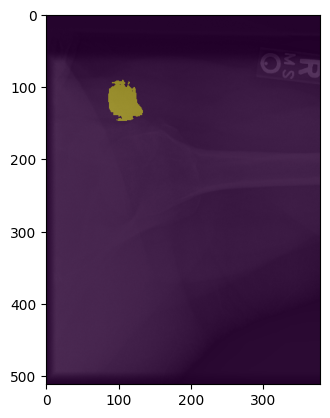

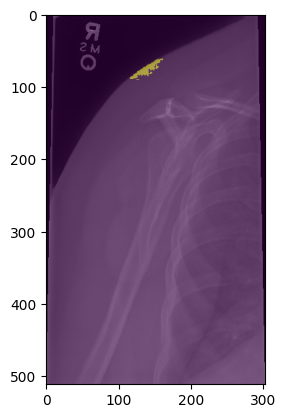

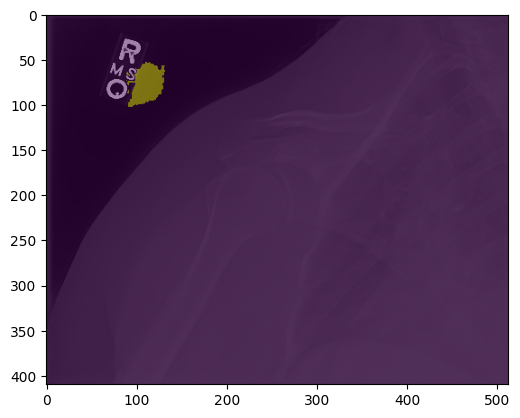

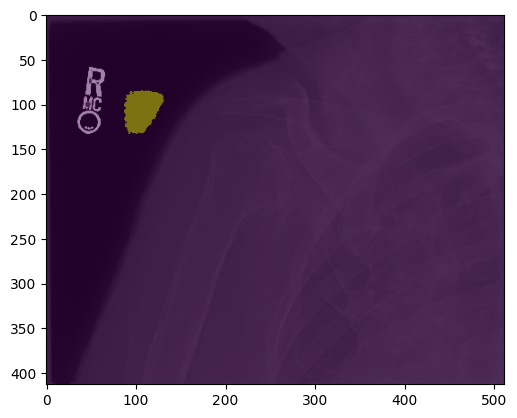

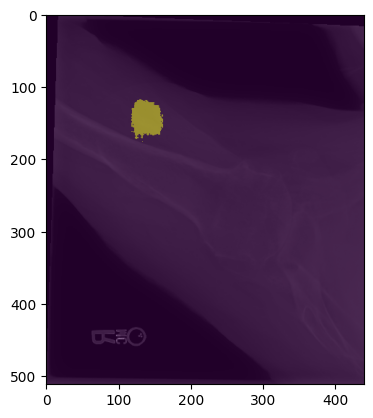

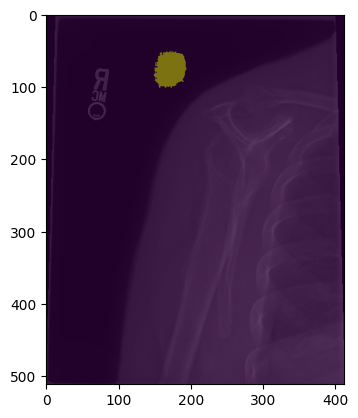

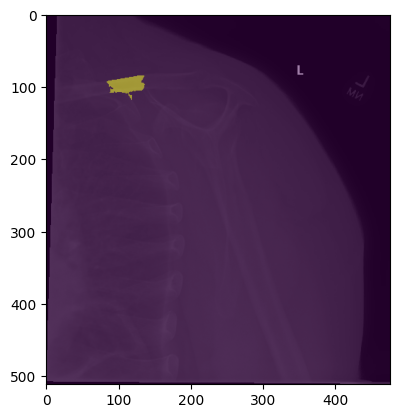

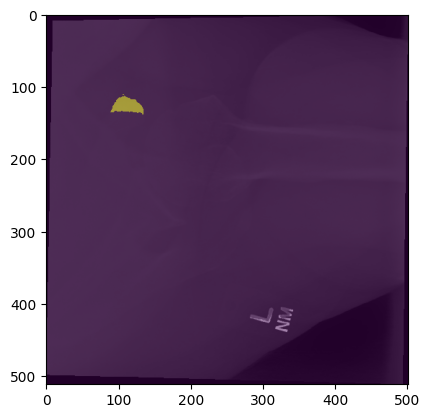

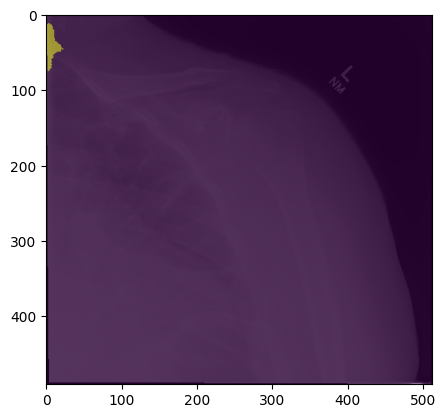

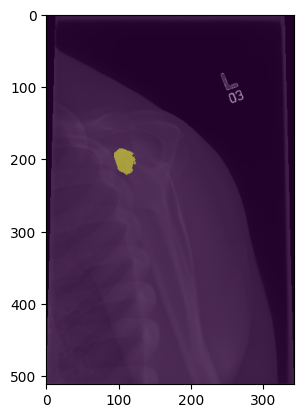

In [ ]:
for idx,row in bounding_box.iterrows():
  images=[]
  if idx<10:
      image_path=row['path']
      image=cv2.imread(image_path)
      image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      images.append(image_rgb)
      bbox=[row['x1'],row['y1'],row['x2'],row['y2']]

      masks=segment_with_bbox(image_path,bbox)
      # display image and masks
      plt.imshow(image_rgb)
      for mask in masks:
         # mask=mask.transpose(1,2,0)
          plt.imshow(mask.squeeze(), alpha=0.5)
      plt.show()
  else:
      break





In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)



In [ ]:
for mask in masks:
  detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
  )
  detections = detections[detections.area == np.max(detections.area)]


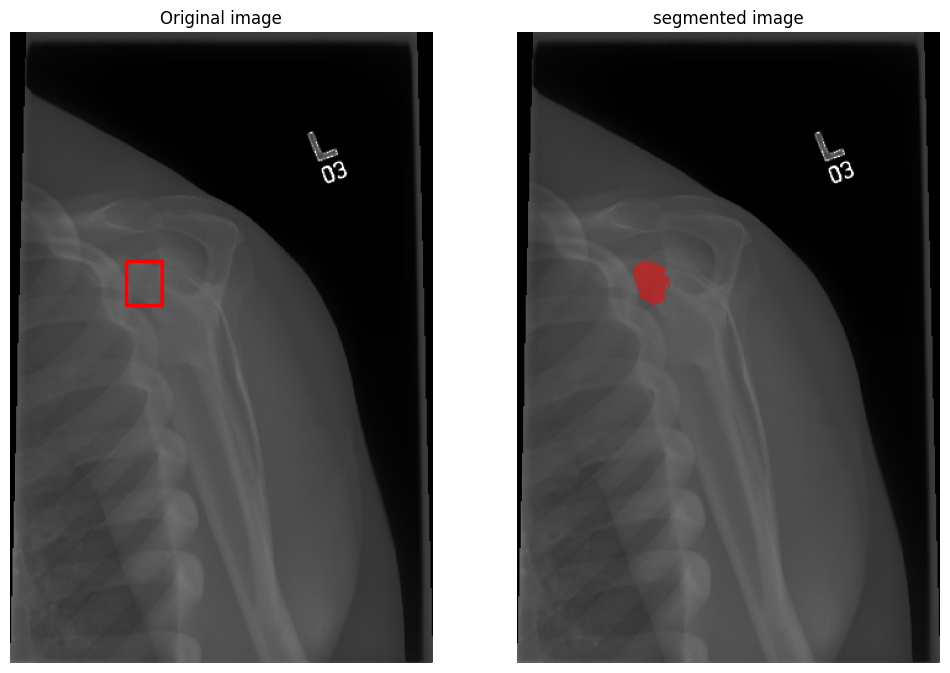

In [ ]:
for image,mask in zip(images,masks):
  detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
  )
  detections = detections[detections.area == np.max(detections.area)]
masks=mask[None, ...]
source_image = box_annotator.annotate(scene=image.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['Original image', 'segmented image']
)

In [ ]:
def expand_bbox(bbox, expansion_factor=0.2):

    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1

    x1 = max(0, int(x1 - width * expansion_factor))
    y1 = max(0, int(y1 - height * expansion_factor))
    x2 = min(image.shape[1], int(x2 + width * expansion_factor))
    y2 = min(image.shape[0], int(y2 + height * expansion_factor))

    return [x1, y1, x2, y2]

In [ ]:
def segment_with_bbox(image_path, bbox, expansion_factor=0.2):

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = []

    # Expand the bounding box
    expanded_bbox = expand_bbox(bbox, expansion_factor)
    x1, y1, x2, y2 = expanded_bbox  # Assign expanded bbox to x1, y1, x2, y2

    predictor = SamPredictor(sam)
    predictor.set_image(image_rgb)
    mask, scores, logits = predictor.predict(
        box=np.array([[x1, y1, x2, y2]]),
        multimask_output=False
    )
    masks.append(mask)

    return masks

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)


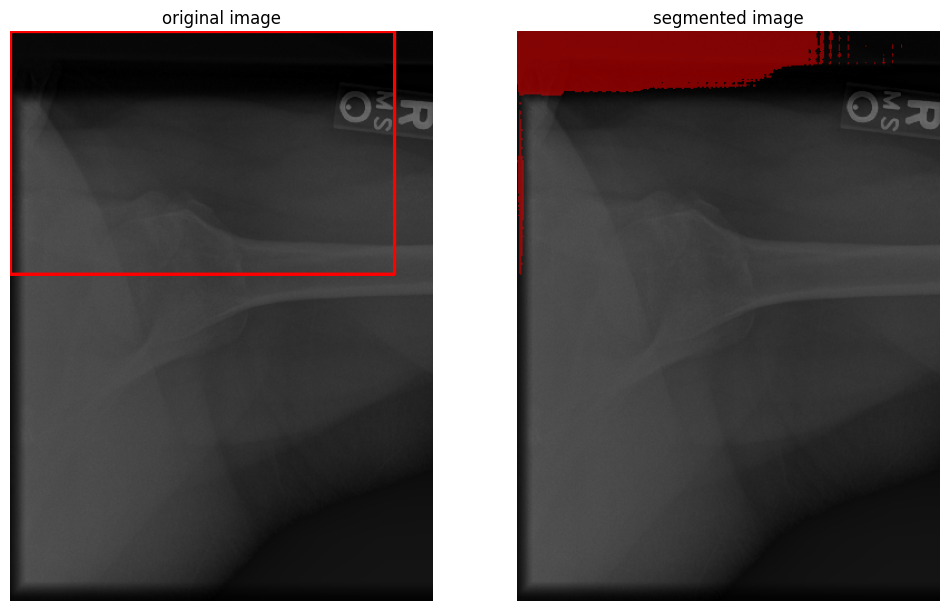

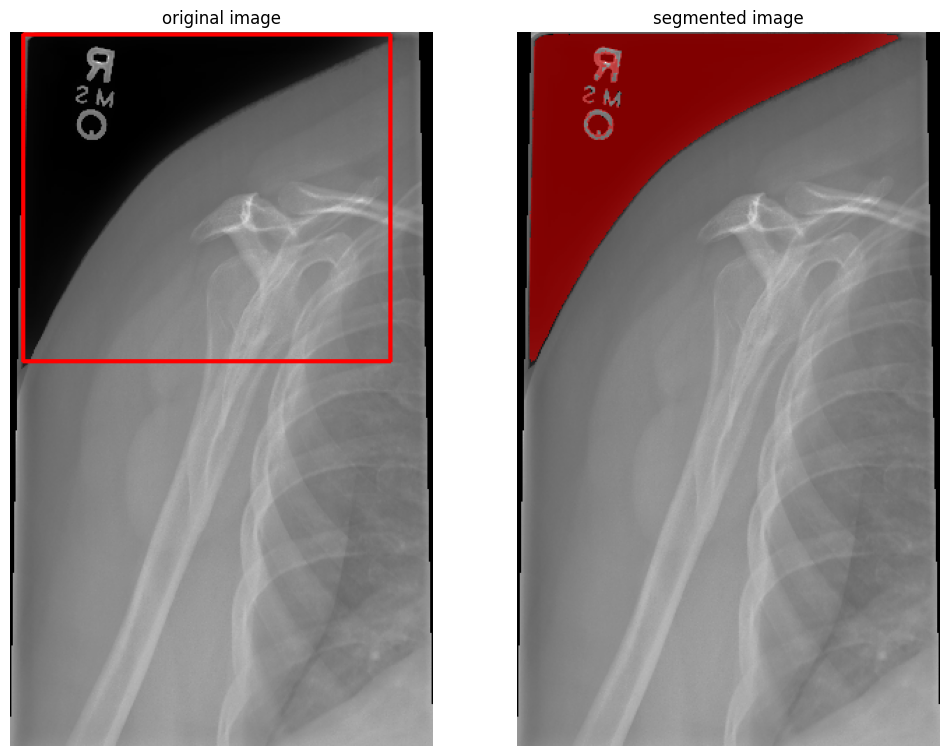

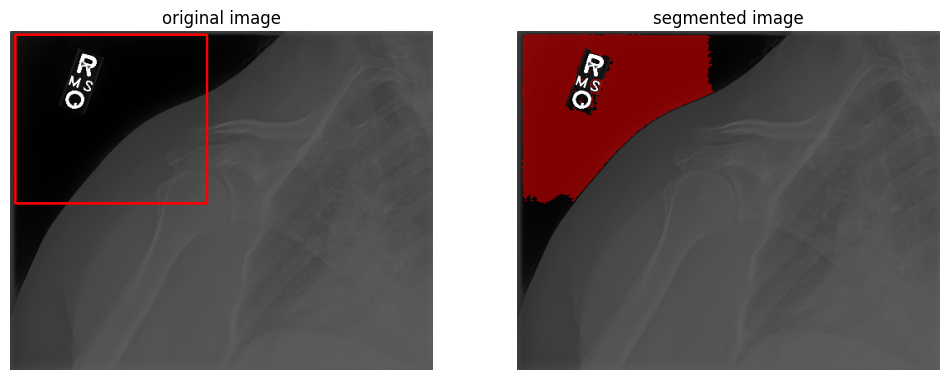

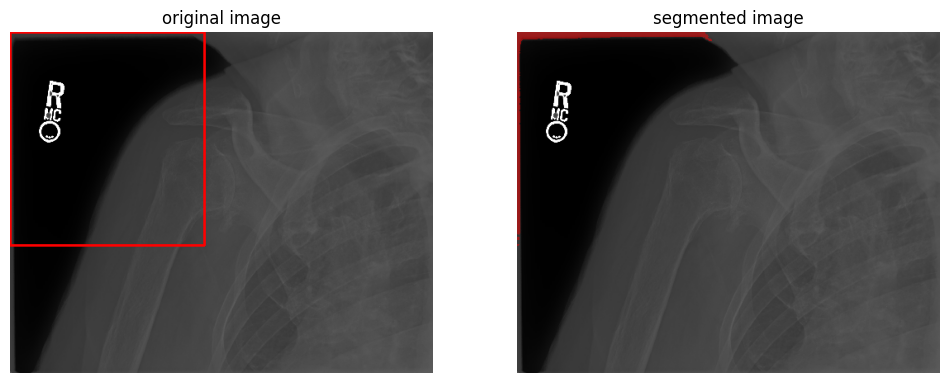

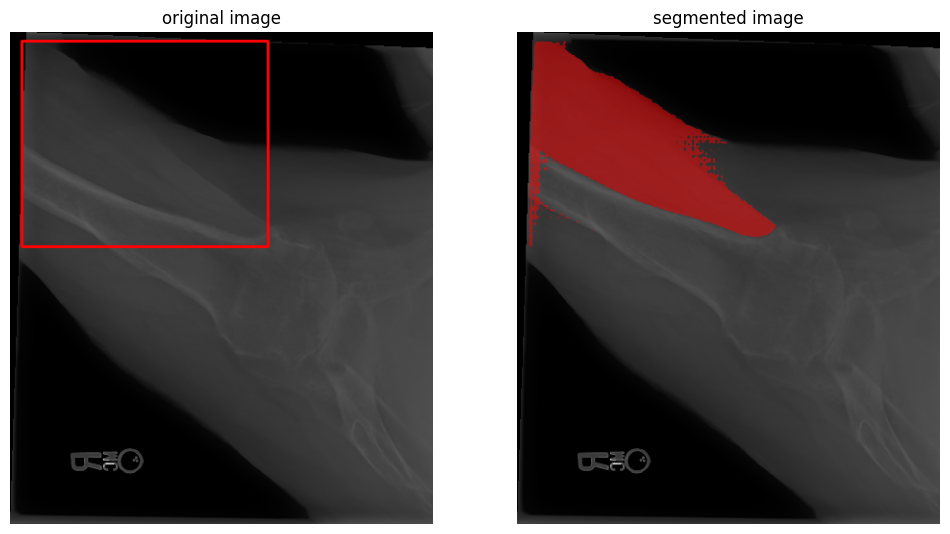

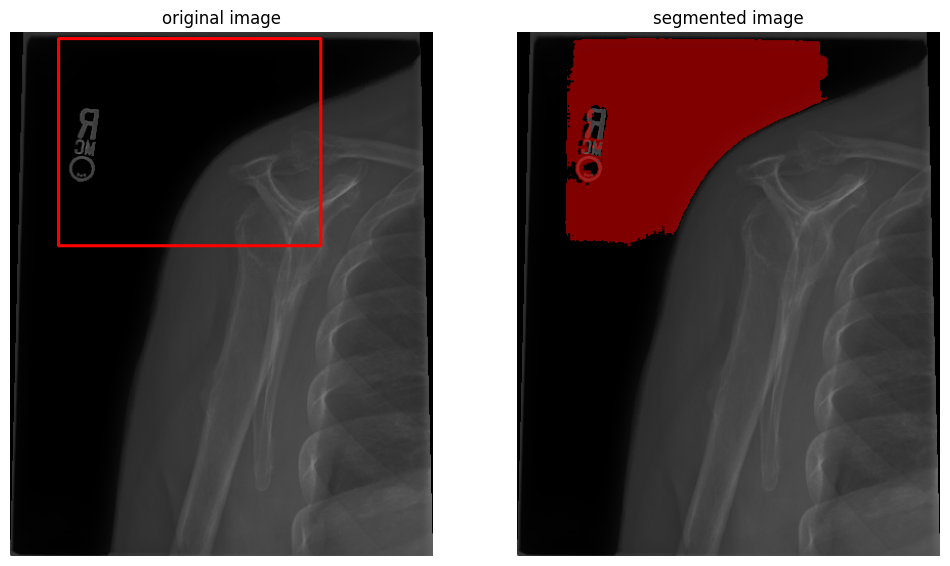

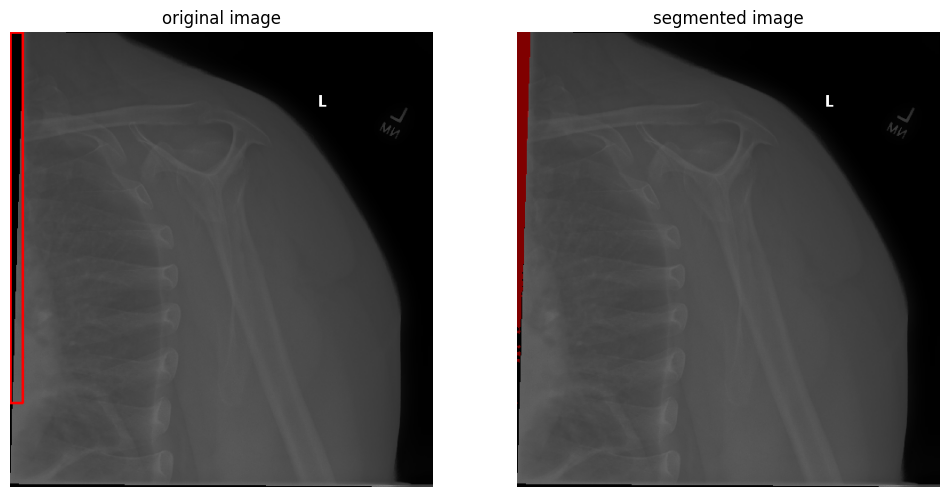

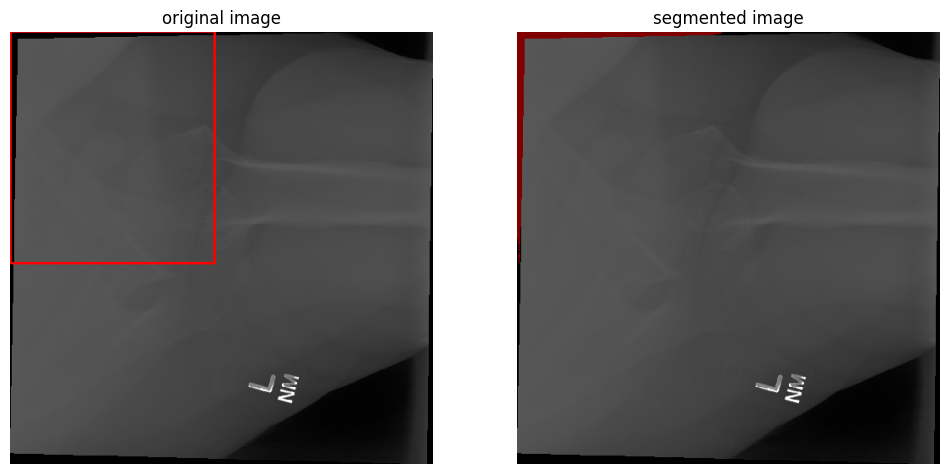

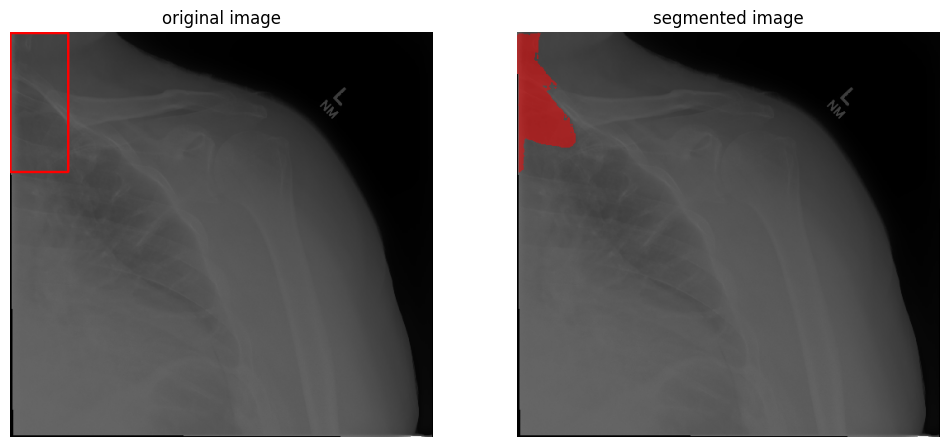

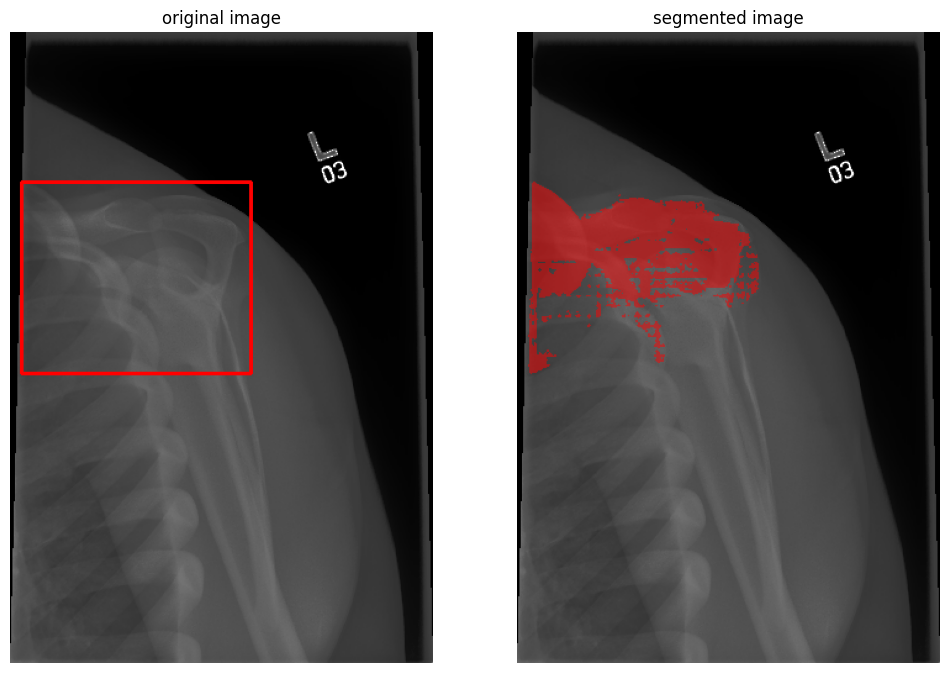

In [ ]:
for idx,row in bounding_box.iterrows():
  images=[]
  if idx<10:
      image_path=row['path']
      image=cv2.imread(image_path)
      image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      images.append(image_rgb)
      bbox=[row['x1'],row['y1'],row['x2'],row['y2']]

      masks=segment_with_bbox(image_path,bbox,expansion_factor=2)

      for mask in masks:
            # Ensure mask has the correct shape if it's not already a list
            if mask.ndim == 2:  # If mask is a single 2D array
                mask = [mask]  # Wrap it in a list

            detections = sv.Detections(
                xyxy=sv.mask_to_xyxy(masks=mask),
                mask=mask
            )

            # Filter detections based on area (if needed)
            detections = detections[detections.area == np.max(detections.area)]

            source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections)
            segmented_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

            sv.plot_images_grid(
                images=[source_image, segmented_image],
                grid_size=(1, 2),
                titles=['original image', 'segmented image']
            )
            plt.show()

      # # display image and masks
      # plt.imshow(image_rgb)
      # for mask in masks:
      #    # mask=mask.transpose(1,2,0)
      #     plt.imshow(mask.squeeze(), alpha=0.5)
      # plt.show()
  else:
      break





In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)



In [ ]:
for mask in masks:
  detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
  )
  detections = detections[detections.area == np.max(detections.area)]


In [ ]:
for image, mask in zip(images, masks):
    # Ensure mask has the correct shape if it's not already a list
    if mask.ndim == 2:  # If mask is a single 2D array
        mask = [mask]  # Wrap it in a list

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=mask),
        mask=mask
    )

    # Filter detections based on area (if needed)
    detections = detections[detections.area == np.max(detections.area)]

    source_image = box_annotator.annotate(scene=image.copy(), detections=detections)
    segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['original image', 'segmented image']
    )
    plt.show()

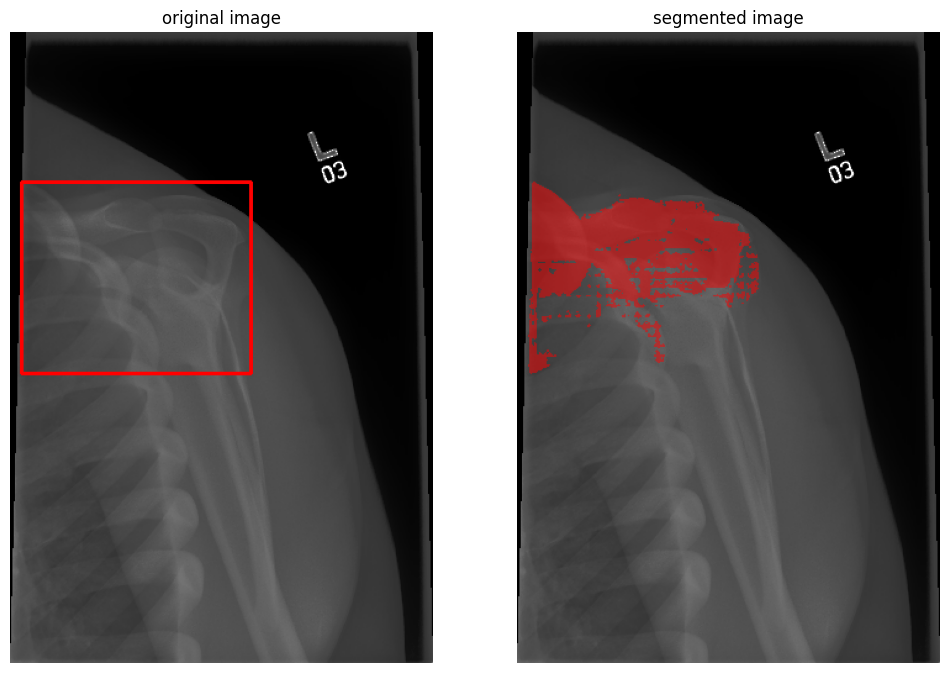

In [ ]:
for image,mask in zip(images,masks):
  detections = sv.Detections( xyxy=sv.mask_to_xyxy(masks=mask), mask=mask)
  detections = detections[detections.area == np.max(detections.area)]
  masks=mask[None, ...]
source_image = box_annotator.annotate(scene=image.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['original image', 'segmented image']
)

In [ ]:
# IS_COLAB = True

# if IS_COLAB:
#     from google.colab import output
#     output.enable_custom_widget_manager()

# from jupyter_bbox_widget import BBoxWidget

# widget = BBoxWidget()
# widget.image = encode_image(IMAGE_PATH)
# widget

In [ ]:
# widget.bboxes

In [ ]:
# default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

# box = widget.bboxes[0] if widget.bboxes else default_box
# box = np.array([
#     box['x'],
#     box['y'],
#     box['x'] + box['width'],
#     box['y'] + box['height']
# ])

In [ ]:
# mask_predictor.set_image(image_rgb)

# masks, scores, logits = mask_predictor.predict(
#     box=box,
#     multimask_output=True
# )

In [ ]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
# mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=masks),
#     mask=masks
# )
# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image.copy(), detections=detections)
# segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [ ]:
# train_images=train_loader.dataset[0]
# train_image_labels=train_loader.dataset[1]

In [ ]:
# test_images=valid_loader.dataset[0]
# test_image_labels=valid_loader.dataset[1]

In [ ]:
# train_loader.dataset[0]

In [ ]:

# for batch_idx, (images, labels) in enumerate(train_loader):
#        for i in range(images.shape[0]):
#            image = images[i].permute(1, 2, 0).cpu().numpy()
#            image = (image * 255).astype(np.uint8)
#            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#            sam_result = mask_generator.generate(image_rgb)
#            mask_annotator=sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
#            detections=sv.Detections.from_sam(sam_result=sam_result)
#            annotated_image=mask_annotator.annotate(scene=image.copy(),detections=detections)
#            sv.plot_images_grid(images=[image,annotated_image],grid_size=(1,2),titles=['original','segmented'])



In [ ]:
# for batch_idx, (images, labels) in enumerate(valid_loader):
#        for i in range(images.shape[0]):
#            image = images[i].permute(1, 2, 0).cpu().numpy()
#            image = (image * 255).astype(np.uint8)
#            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#            sam_result = mask_generator.generate(image_rgb)
#            mask_annotator=sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
#            detections=sv.Detections.from_sam(sam_result=sam_result)
#            annotated_image=mask_annotator.annotate(scene=image.copy(),detections=detections)
#            sv.plot_images_grid(images=[image,annotated_image],grid_size=(1,2),titles=['original','segmented'])


In [ ]:
# sam_result[0].keys()

In [ ]:
# bbox=sam_result[0]['bbox']

In [ ]:
# num_epochs=2
# for epoch in range(num_epochs):
#   for batch_idx, (images, labels) in enumerate(train_loader):
#     images, labels = images.to(device), labels.to(device)

#     # bounding boxes -- need to check this
#     # masks from this model
